# VLSI - SAT Model

#### Definition of the problem
**Input**: A set *R = {r1, . . . , rn}* of *n* rectangles. Each rectangle
*ri ∈ R* has a width *w_i* and a height *h_i* *(w_i, h_i ∈ N)*. A Strip of
width *W ∈ N*.

**Constraints**: Each rectangle cannot overlap with the others
and the edges of the strip and must be parallel to the horizontal
and the vertical axis.

**Question**: What is the minimum height such that the set of
rectangles can be packed in the given strip?

In [ ]:
!pip3 install z3-solver

In [1]:
import os,sys,inspect,getopt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from z3 import *
import math

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

### Useful functions 

In [2]:
def large_rectangles(w_i, w_j, h_i, h_j, W, H):
    if w_i + w_j <= W and h_i + h_j <= H:
        return ""
    elif w_i + w_j > W and h_i + h_j <= H:
        return "W"
    elif w_i + w_j <= W and h_i + h_j > H:
        return "H"

def same_rectangles(w1,w2,h1,h2):
    if w1 == w2 and h1 == h2:
        return True
    else:
        return False

def largest_rectangle(idx, max_idx):
    if idx == max_idx:
        return True
    else:
        return False
    
def no_overlap(W, H, widths, heights, i, j, flip, px, py, lr, ud):            
    dim1,dim2=(widths[i],heights[i]) if not flip else (heights[i],widths[i])
    cts=[]
    
    if lr:
        # lr(r_i,r_j)-> x_j > w_i
        cts.append(Or(
                Not(lr[i][j]),
                Not(px[j][dim1-1]),
            )) 

        for e in range(0,W-dim1):
            cts.append(Or(
                Not(lr[i][j]),
                px[i][e],
                Not(px[j][e+dim1]),
            ))

    if ud:
        # ud(r_i,r_j)-> y_j > h_i
        cts.append(Or(
                Not(ud[i][j]),
                Not(py[j][dim2-1])
            ))

        for f in range(0,H-dim2):
            cts.append(Or(
                Not(ud[i][j]),
                py[i][f],
                Not(py[j][f+dim2])
            ))

    return cts

def no_overlap_r(W, H, widths, heights, i, j, flip_i, flip_j, px, py, lr, ud):
    dim1i,dim2i=(widths[i],heights[i]) if not flip_i else (heights[i],widths[i])
    dim1j,dim2j=(widths[j],heights[j]) if not flip_j else (heights[j],widths[j])
    cts=[]

    # lr(r_i,r_j)-> x_j > w_i
    cts.append(Or(
            Not(lr[i][j]),
            Not(px[j][dim1i-1]),
        )) 

    for e in range(0,W-dim1i):
        cts.append(Or(
            Not(lr[i][j]),
            px[i][e],
            Not(px[j][e+dim1i]),
        ))

    # lr(r_j,r_i)-> x_i > w_j
    cts.append(Or(
            Not(lr[j][i]),
            Not(px[i][dim1j-1])
        ))

    for e in range(0,W-dim1j):
        cts.append(Or(
            Not(lr[j][i]),
            px[j][e],
            Not(px[i][e+dim1j])
        ))

    # ud(r_i,r_j)-> y_j > h_i
    cts.append(Or(
            Not(ud[i][j]),
            Not(py[j][dim2i-1])
        ))

    for f in range(0,H-dim2i):
        cts.append(Or(
            Not(ud[i][j]),
            py[i][f],
            Not(py[j][f+dim2i])
        ))

    # ud(r_j,r_i)-> y_i > h_j
    cts.append(Or(
            Not(ud[j][i]),
            Not(py[i][dim2j-1])
        ))

    for f in range(0,H-dim2j):
        cts.append(Or(
            Not(ud[j][i]),
            py[j][f],
            Not(py[i][f+dim2j])
        ))
    return cts

def getCoords(m, x, y, W, H, n):
    x_sol = []
    y_sol = [] 
    
    for i in range(n):
        j = 0
        while j < W:
            if m.evaluate(x[i][j]):
                x_sol.append(j)
                break
            j += 1

        j = 0
        while j < H:
            if m.evaluate(y[i][j]):
                y_sol.append(j)
                break
            j += 1

    return [x_sol, y_sol]

def getNewDims(model,widths,heights,f, W, H):
    w=[]
    h=[]
    for i in range(len(widths)):
        if model.evaluate(f[i]):
            w.append(heights[i])
            h.append(widths[i])
        else:
            w.append(widths[i])
            h.append(heights[i])
    return w,h 

### Model - Order Encoding

[1] https://web.telegram.org/cd003ba1-9c37-41f3-9be7-dceeb848b5e2

[2] https://sourceforge.net/p/potassco/mailman/attachment/1323943585.4102.431.camel@white.sevalidation.com/1/

In [9]:
'''
 # SEARCH SPACE REDUCTION 
    1. Large Rectangles (LR): 
        Reducing the possibilities for placing large rectangles.
        For each rectangle ri and r j, if wi + w j > W we can not pack
        these rectangles in the horizontal direction. We therefore
        modify non-overlapping constraints.
        This technique is also applicable for the vertical direction.

    2. Same Rectangles (SR):
        For each rectangle ri and r j, if (wi, hi) = (w j, h j) we can 
        fix the positional relation of these rectangles. 
        
    3. Largest Rectangle (LS): 
        Reducing the domain for the largest rectangle.
        With breaking symmetries, we can reduce the domain of
        largest rectangle.

                    D(x_i) = {a ∈ N | 0 ≤ a ≤ floor((W − w_i)/2)}
                    D(y_i) = {a ∈ N | 0 ≤ a ≤ floor((H − h_i)/2)}
'''

def vlsi_sat(instance):
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]
    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    tot_area=sum([w*h for w,h in zip(widths,heights)])
    model = None
    
    naiveSolution = utils.computeMostStupidSolution(instance)
    
    if not naiveSolution:
        return None,0.0

    lb = int(math.ceil(tot_area/W))
    ub = naiveSolution[0][1]+1
    
    print("\n>Starting Lower Bound:", lb)
    print(">Starting Upper Bound:", ub)
    
    H = int((lb+ub)/2)
    
    s_time = time.time()
    ''' SOLVER WITH 5 MINUTES TIMEOUT'''
    while (lb < ub):
        s = Solver()
        s.set("timeout", 300000)
        print(f"\t>Trying H:{H}")
        if (time.time() > s_time + 300):
            break
        
        '''
        ==================================================================
        Let x_i and y_i be integer variables such that the pair (x_i, y_i)
        represents the position of lower left coordinates of the rectangle
        ri in the strip.
        The domains of x_i and y_i are as folbows.
                            D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i}
                            D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i}
        ==================================================================
        Let r_i, r_j ∈ R(i != j) be two rectangles. We use two
        kinds of propositional variables: lr_i,j and ud_i,j.
        lr_i,j is true if r_i are placed at the left to the r_j.
        ud_i,j is true if r_i are placed at the downward to the r_j.

        ==================================================================
        For each rectangles r_i,r_j (i < j), we have the non-overlapping
        constraints:
                            lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i
                                ¬lr_i,j ∨ (x_i + w_i ≤ x_j)
                                ¬lr_j,i ∨ (x_j + w_j ≤ x_i)
                                ¬ud_i,j ∨ (y_i + h_i ≤ y_j)
                                ¬ud_j,i ∨ (y_j + h_j ≤ y_i)
        The parts between parentheses are encoded into SAT by using order
        encoding.
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Order encoding is a generalization of the encoding method
            originally used by Crawford and Baker for Job-Shop
            Scheduling problems.
            It uses a different Boolean variable P_x,a representing x ≤ a
            for each integer variable x and integer value a.
            
            For each rectangle r_i, and integer e and f such that
            0 ≤ e ≤ W − wi and 0 ≤ f ≤ H − h_i, we have the 2-literal
            axiom clauses due to order encoding,
                                ¬ px_i,e ∨ px_i,e+1
                                ¬ py_i, f ∨ py_i, f +1
            ==================================================================
            '''            
            if largest_rectangle(i, largest_idx):
                s.add([px[i][e] for e in range(int((W-widths[i])/2),W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(int((H-heights[i])/2),H)]) # same for the y coordinate 
            else:
                s.add([px[i][e] for e in range(W-widths[i],W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(H-heights[i],H)]) # same for the y coordinate 
            
            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                For each rectangles i,j (i < j), we have the non-overlapping
                constraints as the 4-literal clauses:
                                lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i 
                                
                For each rectangles i, j (i < j), and integer e and f such that
                0 ≤ e < W − wi and 0 ≤ f < H − h j, we also have the
                non-overlapping constraints as the 3-literal clauses:
                                ¬lr_i,j ∨ px_i,e ∨ ¬px_j,e + w_i
                                ¬lr_j,i ∨ px_j,e ∨ ¬px_i,e + w_j
                                ¬ud_i,j ∨ py_i,f ∨ ¬py_j,f + h_i
                                ¬ud_j,i ∨ py_j,f ∨ ¬py_i,f + h_j
                ==================================================================
                '''
                if i<j:  
                    if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "":
                        if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                            s.add(Or(lr[i][j],ud[i][j],ud[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                            )

                            s.add(Or(
                                    Not(ud[i][j]),
                                    lr[j][i]
                            ))
                        else:
                            if not largest_rectangle(j, largest_idx):
                                s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))

                                s.add(
                                    *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                                )
                            else:
                                s.add(Or(lr[j][i],ud[i][j],ud[j][i]))

                                s.add(
                                    *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                                )
                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                        s.add(Or(ud[i][j],ud[j][i]))

                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                            *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                        )

                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                        if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                            s.add(lr[i][j])

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False)
                            )

                            s.add(Or(
                                    Not(ud[i][j]),
                                    lr[j][i]
                            ))  
                        else:                            
                            s.add(Or(lr[i][j],lr[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,False)
                            )


        if s.check() == sat:
            ub = H
            model = s.model()            
            print('\t\t>SAT - ub:',ub)
        else:
            lb = H + 1
            print('\t\t>UNSAT - lb:',lb)
            
        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    if model == None:
        return None, 0.0
    elif e_time <= 300:
        cx,cy=getCoords(model, px, py, W, H, n)
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        return sol, e_time
    else:
        cx,cy=getCoords(model, px, py, W, H, n)
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        return sol, e_time

### Execution

Instance: n=4 w=8 dim=[[3, 3], [3, 5], [5, 3], [5, 5]]

>Starting Lower Bound: 8
>Starting Upper Bound: 9
	>Trying H:8
		>SAT - ub: 8


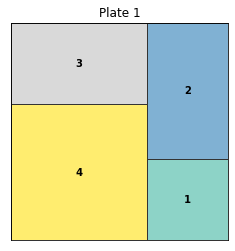

Instance[1] solved in 0.039 s, height: 8


Instance: n=5 w=9 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

>Starting Lower Bound: 9
>Starting Upper Bound: 10
	>Trying H:9
		>SAT - ub: 9


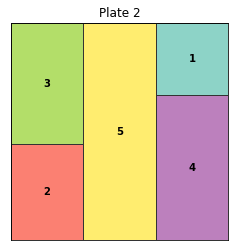

Instance[2] solved in 0.062 s, height: 9


Instance: n=6 w=10 dim=[[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

>Starting Lower Bound: 10
>Starting Upper Bound: 14
	>Trying H:12
		>SAT - ub: 12
	>Trying H:11
		>SAT - ub: 11
	>Trying H:10
		>SAT - ub: 10


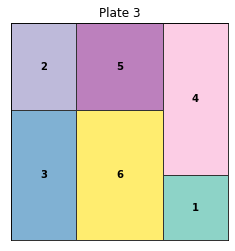

Instance[3] solved in 0.293 s, height: 10


Instance: n=7 w=11 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

>Starting Lower Bound: 11
>Starting Upper Bound: 14
	>Trying H:12
		>SAT - ub: 12
	>Trying H:11
		>SAT - ub: 11


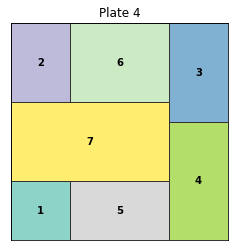

Instance[4] solved in 0.288 s, height: 11


Instance: n=8 w=12 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

>Starting Lower Bound: 12
>Starting Upper Bound: 14
	>Trying H:13
		>SAT - ub: 13
	>Trying H:12
		>SAT - ub: 12


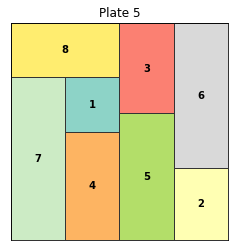

Instance[5] solved in 0.407 s, height: 12


Instance: n=9 w=13 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

>Starting Lower Bound: 13
>Starting Upper Bound: 17
	>Trying H:15
		>SAT - ub: 15
	>Trying H:14
		>SAT - ub: 14
	>Trying H:13
		>SAT - ub: 13


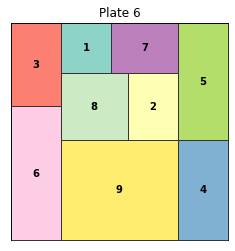

Instance[6] solved in 0.888 s, height: 13


Instance: n=9 w=14 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

>Starting Lower Bound: 14
>Starting Upper Bound: 19
	>Trying H:16
		>SAT - ub: 16
	>Trying H:15
		>SAT - ub: 15
	>Trying H:14
		>SAT - ub: 14


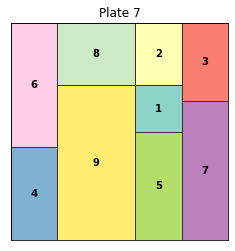

Instance[7] solved in 0.945 s, height: 14


Instance: n=10 w=15 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

>Starting Lower Bound: 15
>Starting Upper Bound: 16
	>Trying H:15
		>SAT - ub: 15


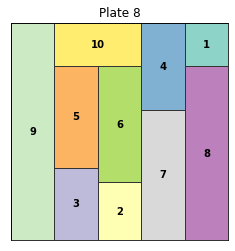

Instance[8] solved in 0.383 s, height: 15


Instance: n=10 w=16 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

>Starting Lower Bound: 16
>Starting Upper Bound: 21
	>Trying H:18
		>SAT - ub: 18
	>Trying H:17
		>SAT - ub: 17
	>Trying H:16
		>SAT - ub: 16


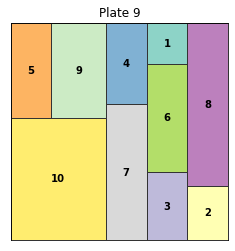

Instance[9] solved in 1.269 s, height: 16


Instance: n=12 w=17 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

>Starting Lower Bound: 17
>Starting Upper Bound: 22
	>Trying H:19
		>SAT - ub: 19
	>Trying H:18
		>SAT - ub: 18
	>Trying H:17
		>SAT - ub: 17


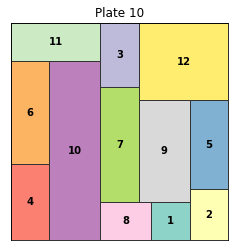

Instance[10] solved in 2.026 s, height: 17


Instance: n=16 w=18 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

>Starting Lower Bound: 18
>Starting Upper Bound: 22
	>Trying H:20
		>SAT - ub: 20
	>Trying H:19
		>SAT - ub: 19
	>Trying H:18
		>SAT - ub: 18


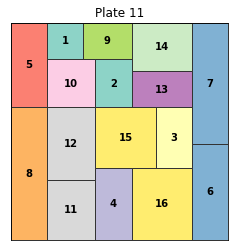

Instance[11] solved in 4.297 s, height: 18


Instance: n=14 w=19 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

>Starting Lower Bound: 19
>Starting Upper Bound: 24
	>Trying H:21
		>SAT - ub: 21
	>Trying H:20
		>SAT - ub: 20
	>Trying H:19
		>SAT - ub: 19


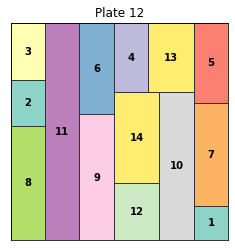

Instance[12] solved in 3.122 s, height: 19


Instance: n=14 w=20 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

>Starting Lower Bound: 20
>Starting Upper Bound: 25
	>Trying H:22
		>SAT - ub: 22
	>Trying H:21
		>SAT - ub: 21
	>Trying H:20
		>SAT - ub: 20


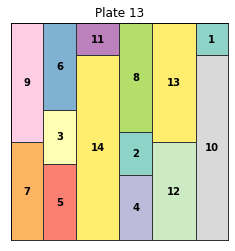

Instance[13] solved in 3.272 s, height: 20


Instance: n=15 w=21 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

>Starting Lower Bound: 21
>Starting Upper Bound: 25
	>Trying H:23
		>SAT - ub: 23
	>Trying H:22
		>SAT - ub: 22
	>Trying H:21
		>SAT - ub: 21


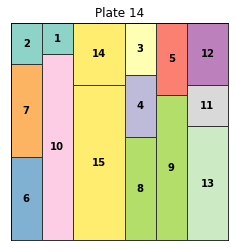

Instance[14] solved in 4.183 s, height: 21


Instance: n=16 w=22 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

>Starting Lower Bound: 22
>Starting Upper Bound: 28
	>Trying H:25
		>SAT - ub: 25
	>Trying H:23
		>SAT - ub: 23
	>Trying H:22
		>SAT - ub: 22


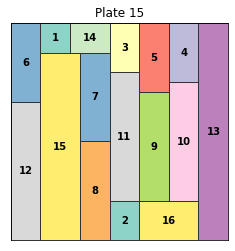

Instance[15] solved in 4.805 s, height: 22


Instance: n=19 w=23 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

>Starting Lower Bound: 23
>Starting Upper Bound: 30
	>Trying H:26
		>SAT - ub: 26
	>Trying H:24
		>SAT - ub: 24
	>Trying H:23
		>SAT - ub: 23


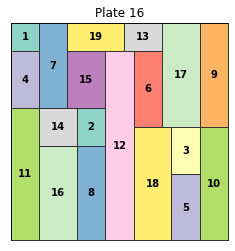

Instance[16] solved in 14.17 s, height: 23


Instance: n=18 w=24 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

>Starting Lower Bound: 24
>Starting Upper Bound: 30
	>Trying H:27
		>SAT - ub: 27
	>Trying H:25
		>SAT - ub: 25
	>Trying H:24
		>SAT - ub: 24


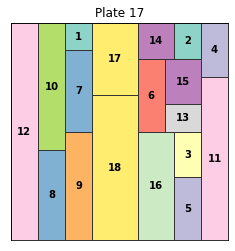

Instance[17] solved in 7.142 s, height: 24


Instance: n=19 w=25 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

>Starting Lower Bound: 25
>Starting Upper Bound: 31
	>Trying H:28
		>SAT - ub: 28
	>Trying H:26
		>SAT - ub: 26
	>Trying H:25
		>SAT - ub: 25


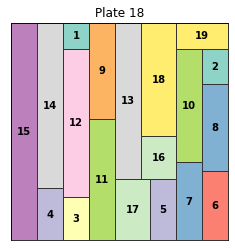

Instance[18] solved in 8.218 s, height: 25


Instance: n=22 w=26 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

>Starting Lower Bound: 26
>Starting Upper Bound: 33
	>Trying H:29
		>SAT - ub: 29
	>Trying H:27
		>SAT - ub: 27
	>Trying H:26
		>SAT - ub: 26


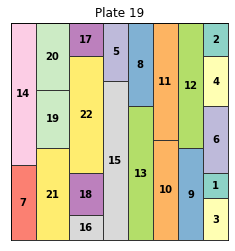

Instance[19] solved in 20.468 s, height: 26


Instance: n=21 w=27 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

>Starting Lower Bound: 27
>Starting Upper Bound: 31
	>Trying H:29
		>SAT - ub: 29
	>Trying H:28
		>SAT - ub: 28
	>Trying H:27
		>SAT - ub: 27


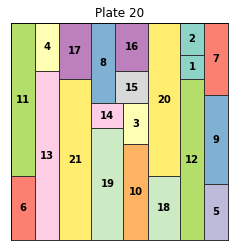

Instance[20] solved in 13.804 s, height: 27


Instance: n=22 w=28 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

>Starting Lower Bound: 28
>Starting Upper Bound: 35
	>Trying H:31
		>SAT - ub: 31
	>Trying H:29
		>SAT - ub: 29
	>Trying H:28
		>SAT - ub: 28


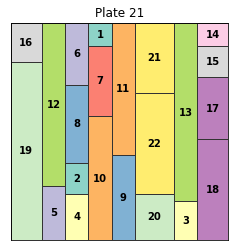

Instance[21] solved in 14.469 s, height: 28


Instance: n=24 w=29 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

>Starting Lower Bound: 29
>Starting Upper Bound: 39
	>Trying H:34
		>SAT - ub: 34
	>Trying H:31
		>SAT - ub: 31
	>Trying H:30
		>SAT - ub: 30
	>Trying H:29
		>SAT - ub: 29


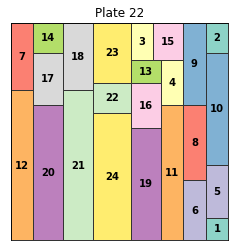

Instance[22] solved in 41.571 s, height: 29


Instance: n=20 w=30 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

>Starting Lower Bound: 30
>Starting Upper Bound: 37
	>Trying H:33
		>SAT - ub: 33
	>Trying H:31
		>SAT - ub: 31
	>Trying H:30
		>SAT - ub: 30


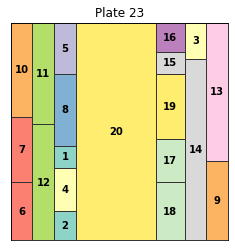

Instance[23] solved in 10.889 s, height: 30


Instance: n=19 w=31 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

>Starting Lower Bound: 31
>Starting Upper Bound: 37
	>Trying H:34
		>SAT - ub: 34
	>Trying H:32
		>SAT - ub: 32
	>Trying H:31
		>SAT - ub: 31


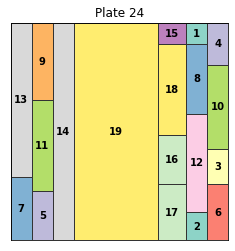

Instance[24] solved in 9.71 s, height: 31


Instance: n=27 w=32 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

>Starting Lower Bound: 32
>Starting Upper Bound: 41
	>Trying H:36
		>SAT - ub: 36
	>Trying H:34
		>SAT - ub: 34
	>Trying H:33
		>SAT - ub: 33
	>Trying H:32
		>SAT - ub: 32


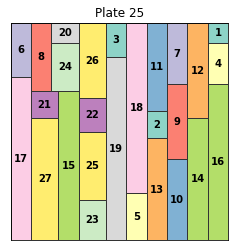

Instance[25] solved in 91.161 s, height: 32


Instance: n=23 w=33 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

>Starting Lower Bound: 33
>Starting Upper Bound: 40
	>Trying H:36
		>SAT - ub: 36
	>Trying H:34
		>SAT - ub: 34
	>Trying H:33
		>SAT - ub: 33


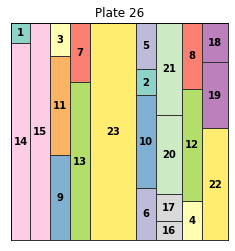

Instance[26] solved in 15.084 s, height: 33


Instance: n=21 w=34 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

>Starting Lower Bound: 34
>Starting Upper Bound: 41
	>Trying H:37
		>SAT - ub: 37
	>Trying H:35
		>SAT - ub: 35
	>Trying H:34
		>SAT - ub: 34


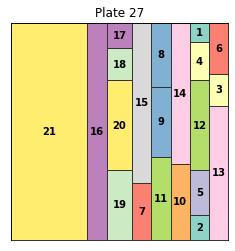

Instance[27] solved in 19.23 s, height: 34


Instance: n=22 w=35 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

>Starting Lower Bound: 35
>Starting Upper Bound: 43
	>Trying H:39
		>SAT - ub: 39
	>Trying H:37
		>SAT - ub: 37
	>Trying H:36
		>SAT - ub: 36
	>Trying H:35
		>SAT - ub: 35


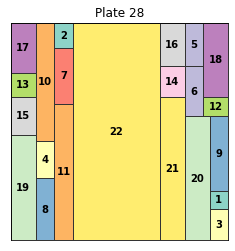

Instance[28] solved in 21.122 s, height: 35


Instance: n=23 w=36 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

>Starting Lower Bound: 36
>Starting Upper Bound: 44
	>Trying H:40
		>SAT - ub: 40
	>Trying H:38
		>SAT - ub: 38
	>Trying H:37
		>SAT - ub: 37
	>Trying H:36
		>SAT - ub: 36


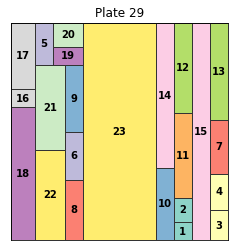

Instance[29] solved in 26.212 s, height: 36


Instance: n=27 w=37 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

>Starting Lower Bound: 37
>Starting Upper Bound: 45
	>Trying H:41
		>SAT - ub: 41
	>Trying H:39
		>SAT - ub: 39
	>Trying H:38
		>SAT - ub: 38
	>Trying H:37
		>SAT - ub: 37


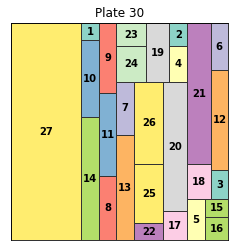

Instance[30] solved in 171.645 s, height: 37


Instance: n=19 w=38 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

>Starting Lower Bound: 38
>Starting Upper Bound: 44
	>Trying H:41
		>SAT - ub: 41
	>Trying H:39
		>SAT - ub: 39
	>Trying H:38
		>SAT - ub: 38


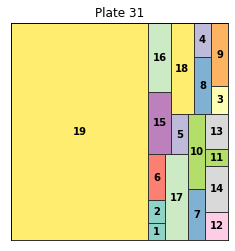

Instance[31] solved in 16.432 s, height: 38


Instance: n=29 w=39 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

>Starting Lower Bound: 39
>Starting Upper Bound: 44
	>Trying H:41
		>SAT - ub: 41
	>Trying H:40
		>SAT - ub: 40
	>Trying H:39
		>SAT - ub: 39


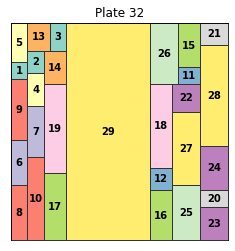

Instance[32] solved in 132.81 s, height: 39


Instance: n=20 w=40 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

>Starting Lower Bound: 40
>Starting Upper Bound: 56
	>Trying H:48
		>SAT - ub: 48
	>Trying H:44
		>SAT - ub: 44
	>Trying H:42
		>SAT - ub: 42
	>Trying H:41
		>SAT - ub: 41
	>Trying H:40
		>SAT - ub: 40


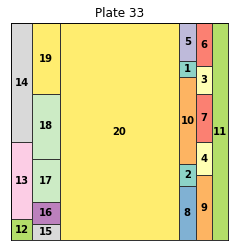

Instance[33] solved in 23.944 s, height: 40


Instance: n=25 w=15 dim=[[3, 11], [3, 13], [2, 9], [2, 7], [3, 9], [3, 7], [2, 11], [2, 13], [4, 11], [4, 13], [5, 3], [2, 11], [2, 2], [3, 11], [3, 2], [4, 5], [4, 6], [2, 12], [2, 1], [5, 3], [5, 13], [4, 12], [4, 1], [2, 5], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 46
	>Trying H:43
		>SAT - ub: 43
	>Trying H:41
		>SAT - ub: 41
	>Trying H:40
		>SAT - ub: 40


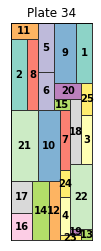

Instance[34] solved in 16.506 s, height: 40


Instance: n=25 w=15 dim=[[2, 11], [3, 2], [7, 10], [4, 8], [5, 9], [2, 7], [1, 4], [1, 6], [5, 4], [3, 8], [3, 1], [5, 5], [1, 3], [4, 12], [2, 6], [4, 2], [4, 11], [2, 10], [2, 3], [2, 11], [4, 3], [4, 26], [4, 8], [2, 3], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42
	>Trying H:41
		>SAT - ub: 41
	>Trying H:40
		>SAT - ub: 40


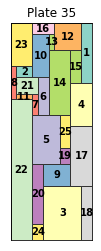

Instance[35] solved in 16.781 s, height: 40


Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42
	>Trying H:41
		>SAT - ub: 41
	>Trying H:40
		>SAT - ub: 40


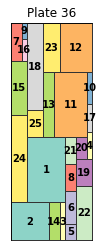

Instance[36] solved in 19.018 s, height: 40


Instance: n=28 w=30 dim=[[5, 7], [5, 14], [8, 14], [8, 4], [13, 21], [11, 7], [11, 14], [5, 14], [5, 4], [3, 18], [3, 21], [11, 17], [11, 4], [4, 7], [4, 5], [7, 6], [5, 18], [5, 3], [3, 7], [3, 5], [4, 18], [4, 3], [2, 12], [2, 6], [5, 18], [5, 21], [3, 17], [3, 4]]

>Starting Lower Bound: 60
>Starting Upper Bound: 74
	>Trying H:67
		>SAT - ub: 67
	>Trying H:63
		>SAT - ub: 63
	>Trying H:61
		>SAT - ub: 61
	>Trying H:60
		>SAT - ub: 60


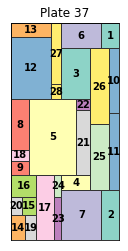

Instance[37] solved in 62.497 s, height: 60


Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]

>Starting Lower Bound: 60
>Starting Upper Bound: 75
	>Trying H:67
		>SAT - ub: 67
	>Trying H:63
		>SAT - ub: 63
	>Trying H:61
		>SAT - ub: 61
	>Trying H:60
		>UNSAT - lb: 61


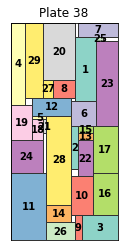

Instance[38] solved in 347.591 s, height: 61


Instance: n=28 w=30 dim=[[9, 24], [9, 8], [9, 11], [9, 17], [4, 24], [4, 8], [1, 6], [1, 5], [4, 17], [3, 6], [3, 5], [12, 5], [12, 13], [14, 14], [2, 14], [2, 2], [8, 3], [8, 9], [12, 14], [12, 2], [6, 3], [6, 9], [2, 5], [2, 13], [3, 18], [3, 14], [3, 16], [3, 12]]

>Starting Lower Bound: 60
>Starting Upper Bound: 70
	>Trying H:65
		>SAT - ub: 65
	>Trying H:62
		>SAT - ub: 62
	>Trying H:61
		>SAT - ub: 61
	>Trying H:60


Exception ignored in: <function AstRef.__del__ at 0x0000014E84EDB8C8>
Traceback (most recent call last):
  File "C:\Users\Antonio\anaconda3\envs\COMB\lib\site-packages\z3\z3.py", line 346, in __del__
    Z3_dec_ref(self.ctx.ref(), self.as_ast())
  File "C:\Users\Antonio\anaconda3\envs\COMB\lib\site-packages\z3\z3.py", line 557, in as_ast
    return Z3_sort_to_ast(self.ctx_ref(), self.ast)
  File "C:\Users\Antonio\anaconda3\envs\COMB\lib\site-packages\z3\z3core.py", line 2690, in Z3_sort_to_ast
    r = _elems.f(a0, a1)
KeyboardInterrupt


KeyboardInterrupt: 

In [22]:
from_ins = 1
to_ins   = 40

times = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat(instance)
    
    times.append(round(e_time,3))
    if sol == None:
        print(">Unfeasible.")
    elif e_time > 300:
        print(">Out of time.")
    else:
        # Write to file
        utils.writeSolution('./outputs/out-' + str(ins) + '.txt', sol)

        utils.display_solution(sol, title= f'Plate {ins}')
        
        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {sol[0][1]}')
    print('========================================================================================')
    print('\n')

Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]

>Starting Lower Bound: 60
>Starting Upper Bound: 75
	>Trying H:67
		>SAT - ub: 67
	>Trying H:63
		>SAT - ub: 63
	>Trying H:61
		>SAT - ub: 61
	>Trying H:60
		>SAT - ub: 60


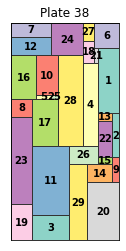

Instance[38] solved in 119.034 s, height: 60


Instance: n=28 w=30 dim=[[9, 24], [9, 8], [9, 11], [9, 17], [4, 24], [4, 8], [1, 6], [1, 5], [4, 17], [3, 6], [3, 5], [12, 5], [12, 13], [14, 14], [2, 14], [2, 2], [8, 3], [8, 9], [12, 14], [12, 2], [6, 3], [6, 9], [2, 5], [2, 13], [3, 18], [3, 14], [3, 16], [3, 12]]

>Starting Lower Bound: 60
>Starting Upper Bound: 70
	>Trying H:65
		>SAT - ub: 65
	>Trying H:62
		>SAT - ub: 62
	>Trying H:61
		>SAT - ub: 61
	>Trying H:60
		>SAT - ub: 60


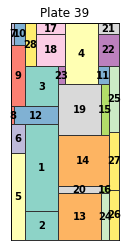

Instance[39] solved in 100.526 s, height: 60


Instance: n=73 w=60 dim=[[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]

>Starting Lower Bound: 90
>Starting Upper Bound: 104
	>Trying H:97
		>SAT - ub: 97
	>Trying H:93
		>SAT - ub: 93
	>Trying H:91
		>SAT - ub: 91
	>Trying H:90


IndexError: list index out of range

In [12]:
from_ins = 38
to_ins   = 40

times = []
for ins in range(from_ins, min(to_ins+1,43)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat(instance)
    
    times.append(round(e_time,3))
    if sol == None:
        print(">Unfeasible.")
    elif e_time > 300:
        print(">Out of time.")
    else:
        # Write to file
        utils.writeSolution('./outputs/out-' + str(ins) + '.txt', sol)

        utils.display_solution(sol, title= f'Plate {ins}')
        
        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {sol[0][1]}')
    print('========================================================================================')
    print('\n')

In [23]:
times_prima = times_r

print(times_prima)
print(times)

[0.039, 0.062, 0.293, 0.288, 0.407, 0.888, 0.945, 0.383, 1.269, 2.026, 4.297, 3.122, 3.272, 4.183, 4.805, 14.17, 7.142, 8.218, 20.468, 13.804, 14.469, 41.571, 10.889, 9.71, 91.161, 15.084, 19.23, 21.122, 26.212, 171.645, 16.432, 132.81, 23.944, 16.506, 16.781, 19.018, 62.497, 347.591]


In [ ]:
f = open('./vlsi_SAT.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
for ins in range(1,41):
    row = ins+1 + ";" + times[ins] + ";" + utils.readSolution('./outputs/out-' + str(ins) + '.txt') 
    writer.writerow(row)

# close the file
f.close()

### Model with rotations

In [97]:
def vlsi_sat_rotations(instance):
    
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]
    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    tot_area=sum([w*h for w,h in zip(widths,heights)])
    model = None
    
    naiveSolution = utils.computeMostStupidSolution(instance)
    
    if not naiveSolution:
        return None

    lb = int(math.ceil(tot_area/W))
    ub = naiveSolution[0][1]+1
    
    print("\n>Starting Lower Bound:", lb)
    print(">Starting Upper Bound:", ub)
    
    H = int((lb+ub)/2)
    
    s_time = time.time()
    
    ''' SOLVER WITH 5 MINUTES TIMEOUT'''
    while (lb < ub):
        s = Solver()
        s.set("timeout", 300000)
        print(f"\t>Trying H:{H}")
        if (time.time() > s_time + 300):
            break
        '''
        ==================================================================
        The variable "f" points wether a component is flipped or not.
        ==================================================================
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]
        f = [Bool(f"f{i+1}") for i in range(n)] # f[i]: block i is flipped

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Ranges of each component change depending on "f".
            ==================================================================
            '''
            if largest_rectangle(i, largest_idx):
                s.add(Or(
                        And (Not(f[i]), And([px[i][e] for e in range(int((W-widths[i])/2),W)])),
                        And ( f[i],      And([px[i][e] for e in range(int((W-heights[i])/2),W)]))
                    )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 

                s.add(Or(
                    And (Not(f[i]), And([py[i][f] for f in range(int((H-heights[i])/2),H)])),
                    And (f[i],      And([py[i][f] for f in range(int((H-widths[i])/2),H)]))
                    ))
                    # same for the y coordinate 
            else:
                s.add(Or(
                        And (Not(f[i]), And([px[i][e] for e in range(W-widths[i],W)])),
                        And ( f[i],      And([px[i][e] for e in range(W-heights[i],W)]))
                    )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 

                s.add(Or(
                    And (Not(f[i]), And([py[i][f] for f in range(H-heights[i],H)])),
                    And (f[i],      And([py[i][f] for f in range(H-widths[i],H)]))
                    ))
                    # same for the y coordinate  

            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                We must take in account the four possible orientations of
                two components.
                ==================================================================
                '''
                if i<j:
                    s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))
                    wi,wj,hi,hj=widths[i],widths[j],heights[i],heights[j]                 
                    cts=[] 
                    if wi<=W and hi<=H and wj<=W and hj<=H: 
                        cts.append(And(Not(f[i]),Not(f[j]),*no_overlap_r(i,j,False,False)))
                    if wi<=H and hi<=W and wj<=W and hj<=H:  
                        cts.append(And(f[i],Not(f[j]),*no_overlap_r(W,H,wi,wj,i,j,True,False,px,py,lr,ud)))
                    if wi<=W and hi<=H and wj<=H and hj<=W:
                        cts.append(And(Not(f[i]),f[j],*no_overlap_r(W,H,wi,wj,i,j,False,True,px,py,lr,ud)))
                    if wi<=H and hi<=W and wj<=H and hj<=W:
                        cts.append(And(f[i],f[j],*no_overlap_r(W,H,wi,wj,i,j,True,True,px,py,lr,ud)))
                    s.add(Or(cts))

        if s.check() == sat:
            ub = H
            model = s.model()            
            print('\t\t>SAT - ub:',ub)
        else:
            lb = H + 1
            print('\t\t>UNSAT - lb:',lb)

            
        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    if model != None:
        cx,cy=getCoords(model, px, py, W, H, n)
        new_w,new_h=getNewDims(model,widths,heights,f,W,H)
        sol=[[W,H]]+[[new_w[i],new_h[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        return sol, e_time
    else:
        return None, 0.0

Instance: n=4 w=8 dim=[[3, 3], [3, 5], [5, 3], [5, 5]]

	>Starting Lower Bound: 8
	>Starting Upper Bound: 9
	>Trying H:8
		>SAT - ub: 8


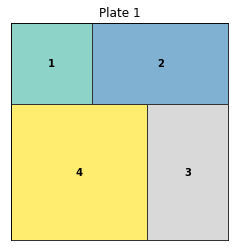

Instance[1] solved in 0.122 s, height: 3


Instance: n=5 w=9 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

	>Starting Lower Bound: 9
	>Starting Upper Bound: 10
	>Trying H:9
		>SAT - ub: 9


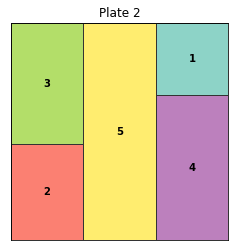

Instance[2] solved in 0.219 s, height: 3


Instance: n=6 w=10 dim=[[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

	>Starting Lower Bound: 10
	>Starting Upper Bound: 14
	>Trying H:12
		>SAT - ub: 12
	>Trying H:11
		>SAT - ub: 11
	>Trying H:10
		>SAT - ub: 10


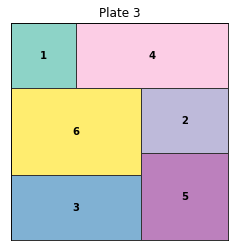

Instance[3] solved in 1.117 s, height: 3


Instance: n=7 w=11 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

	>Starting Lower Bound: 11
	>Starting Upper Bound: 14
	>Trying H:12
		>SAT - ub: 12
	>Trying H:11
		>SAT - ub: 11


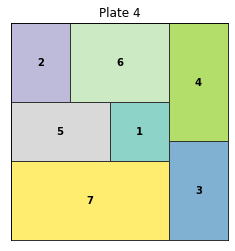

Instance[4] solved in 1.136 s, height: 3


Instance: n=8 w=12 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

	>Starting Lower Bound: 12
	>Starting Upper Bound: 14
	>Trying H:13
		>SAT - ub: 13
	>Trying H:12
		>SAT - ub: 12


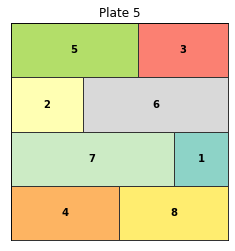

Instance[5] solved in 1.713 s, height: 3


Instance: n=9 w=13 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

	>Starting Lower Bound: 13
	>Starting Upper Bound: 17
	>Trying H:15
		>SAT - ub: 15
	>Trying H:14
		>SAT - ub: 14
	>Trying H:13
		>SAT - ub: 13


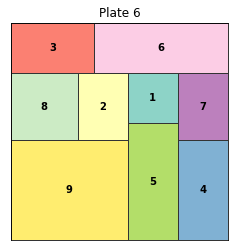

Instance[6] solved in 3.694 s, height: 3


Instance: n=9 w=14 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

	>Starting Lower Bound: 14
	>Starting Upper Bound: 19
	>Trying H:16
		>SAT - ub: 16
	>Trying H:15
		>SAT - ub: 15
	>Trying H:14
		>SAT - ub: 14


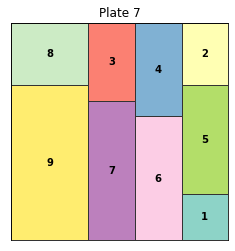

Instance[7] solved in 3.954 s, height: 3


Instance: n=10 w=15 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

	>Starting Lower Bound: 15
	>Starting Upper Bound: 16
	>Trying H:15
		>SAT - ub: 15


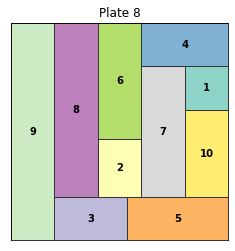

Instance[8] solved in 1.73 s, height: 3


Instance: n=10 w=16 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

	>Starting Lower Bound: 16
	>Starting Upper Bound: 21
	>Trying H:18
		>SAT - ub: 18
	>Trying H:17
		>SAT - ub: 17
	>Trying H:16
		>SAT - ub: 16


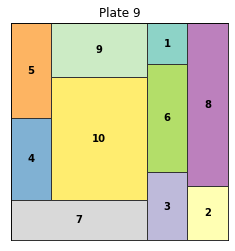

Instance[9] solved in 5.462 s, height: 3


Instance: n=12 w=17 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

	>Starting Lower Bound: 17
	>Starting Upper Bound: 22
	>Trying H:19
		>SAT - ub: 19
	>Trying H:18
		>SAT - ub: 18
	>Trying H:17
		>SAT - ub: 17


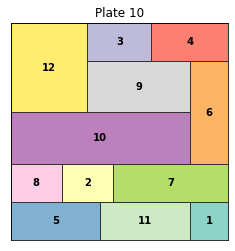

Instance[10] solved in 9.234 s, height: 3


Instance: n=16 w=18 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

	>Starting Lower Bound: 18
	>Starting Upper Bound: 22
	>Trying H:20
		>SAT - ub: 20
	>Trying H:19
		>SAT - ub: 19
	>Trying H:18
		>SAT - ub: 18


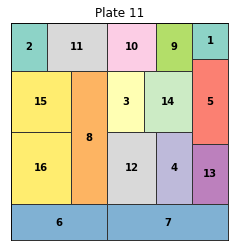

Instance[11] solved in 20.951 s, height: 3


Instance: n=14 w=19 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

	>Starting Lower Bound: 19
	>Starting Upper Bound: 24
	>Trying H:21
		>SAT - ub: 21
	>Trying H:20
		>SAT - ub: 20
	>Trying H:19
		>SAT - ub: 19


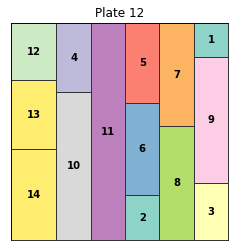

Instance[12] solved in 13.778 s, height: 3


Instance: n=14 w=20 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

	>Starting Lower Bound: 20
	>Starting Upper Bound: 25
	>Trying H:22
		>SAT - ub: 22
	>Trying H:21
		>SAT - ub: 21
	>Trying H:20
		>SAT - ub: 20


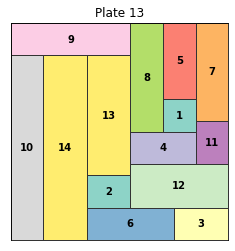

Instance[13] solved in 14.886 s, height: 3


Instance: n=15 w=21 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

	>Starting Lower Bound: 21
	>Starting Upper Bound: 25
	>Trying H:23
		>SAT - ub: 23
	>Trying H:22
		>SAT - ub: 22
	>Trying H:21
		>SAT - ub: 21


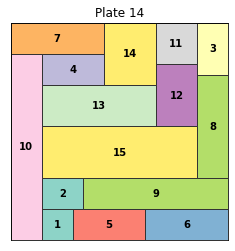

Instance[14] solved in 18.377 s, height: 3


Instance: n=16 w=22 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

	>Starting Lower Bound: 22
	>Starting Upper Bound: 28
	>Trying H:25
		>SAT - ub: 25
	>Trying H:23
		>SAT - ub: 23
	>Trying H:22
		>SAT - ub: 22


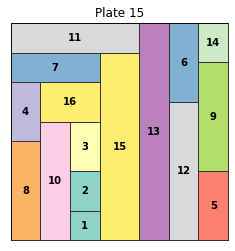

Instance[15] solved in 21.938 s, height: 3


Instance: n=19 w=23 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

	>Starting Lower Bound: 23
	>Starting Upper Bound: 30
	>Trying H:26
		>SAT - ub: 26
	>Trying H:24
		>SAT - ub: 24
	>Trying H:23
		>SAT - ub: 23


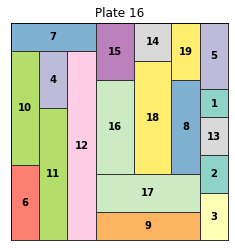

Instance[16] solved in 55.673 s, height: 3


Instance: n=18 w=24 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

	>Starting Lower Bound: 24
	>Starting Upper Bound: 30
	>Trying H:27
		>SAT - ub: 27
	>Trying H:25
		>SAT - ub: 25
	>Trying H:24
		>SAT - ub: 24


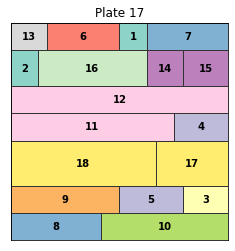

Instance[17] solved in 53.252 s, height: 3


Instance: n=19 w=25 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

	>Starting Lower Bound: 25
	>Starting Upper Bound: 31
	>Trying H:28
		>SAT - ub: 28
	>Trying H:26
		>SAT - ub: 26
	>Trying H:25
		>SAT - ub: 25


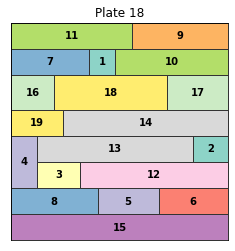

Instance[18] solved in 69.734 s, height: 3


Instance: n=22 w=26 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

	>Starting Lower Bound: 26
	>Starting Upper Bound: 33
	>Trying H:29
		>SAT - ub: 29
	>Trying H:27
		>SAT - ub: 27
	>Trying H:26


In [ ]:
from_ins = 1
to_ins   = 40

times_r = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat_rotations(instance)
    
    times_r.append(round(e_time,3))
    if sol == None:
        if e_time < 300:
            print(">Unfeasible.")
        else:
            print(">Out of time.")
    else:
        # Write to file
        utils.writeSolution('./outputs_rot/out-' + str(ins) + '.txt', sol)

        # Display
        utils.display_solution(sol, title= f'Plate {ins}')
        
        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {H}')
    print('========================================================================================')
    print('\n')

In [ ]:
print(times)
print("\n")
print(times_r)